# Dataiku Interview Challenge

This US Census dataset contains detailed but anonymized information for approximately 300,000 people.

The archive contains 3 files: <br>
o A large learning .csv file <br>
o Another test .csv file <br>
o A metadata file describing the columns of the two above mentioned files (identical for both)

The goal of this exercise is to model the information contained in the last column (42nd), i.e., which people make more or less than $50,000 / year, from the information contained in the other columns. The exercise here consists of modeling a binary variable. 


## Import Modules

In [48]:
print('Importing Modules ...\n')

import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score


print('Imported ...')

Importing Modules ...

Imported ...


## Reading Training Data

In [49]:
#Load Training Data
df_learning = pd.read_csv('census_income_learn.csv', header = None, skipinitialspace = True, na_values= "Not in universe")
print('Training set contains approximately ',len(df_learning),'samples and', len(df_learning.columns) ,'features')
df_learning.head(2)

Training set contains approximately  199523 samples and 42 features


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,Not in universe or children,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.


## Reading Test Data

In [50]:
#Load Test Data
df_test = pd.read_csv('census_income_test.csv', header = None ,skipinitialspace = True, na_values= "Not in universe" )
print('Test set contains approximately',len(df_test), 'samples and', len(df_test.columns) ,'features')
df_test.head(2)

Test set contains approximately 99762 samples and 42 features


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,NaN,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,NaN,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,NaN,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,26,95,- 50000.


## Loading Columns

In [51]:
with open("col.txt", 'r') as f :
    all_col = f.readlines()

col_names = [elt.split(":")[0].strip() for elt in all_col] + ["target"]
df_learning.columns = col_names
df_test.columns = col_names

## Initial Quick Data Visualization and Analysis

Quick statistic based and univariate audit of the different columns’ content and produce the results in visual / graphic format from the test and training file

In [52]:
df_learning.describe(include = 'all')

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
count,199523.000000,99278,199523.000000,199523.000000,199523,199523.000000,12580,199523,199523,98839,...,199523,199523,199523,199523,199523.000000,1984,199523.000000,199523.000000,199523.000000,199523
unique,NaN,8,NaN,NaN,17,NaN,2,7,24,14,...,43,43,43,5,NaN,2,NaN,NaN,NaN,2
top,NaN,Private,NaN,NaN,High school graduate,NaN,High school,Never married,Not in universe or children,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,NaN,No,NaN,NaN,NaN,- 50000.
freq,NaN,72028,NaN,NaN,48407,NaN,6892,86485,100684,14837,...,159163,160479,176989,176992,NaN,1593,NaN,NaN,NaN,187141
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,NaN
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


In [53]:
df_test.describe(include = 'all')

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
count,99762.000000,49683,99762.000000,99762.000000,99762,99762.000000,6338,99762,99762,49479,...,99762,99762,99762,99762,99762.000000,1027,99762.000000,99762.000000,99762.000000,99762
unique,NaN,8,NaN,NaN,17,NaN,2,7,24,14,...,43,43,43,5,NaN,2,NaN,NaN,NaN,2
top,NaN,Private,NaN,NaN,High school graduate,NaN,High school,Never married,Not in universe or children,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,NaN,No,NaN,NaN,NaN,- 50000.
freq,NaN,36071,NaN,NaN,24147,NaN,3506,43143,50283,7252,...,79368,80013,88353,88355,NaN,828,NaN,NaN,NaN,93576
mean,34.628596,NaN,15.332812,11.331118,NaN,54.461268,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.178505,NaN,1.519827,23.185331,94.500652,NaN
std,22.333449,NaN,18.026709,14.459589,NaN,270.202643,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.558316,NaN,0.848229,24.389184,0.500002,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,16.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,95.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


#### Highlighting the percentage of null values in each column

In [54]:
print((df_learning.isnull().sum()/len(df_learning)*100))

age                                            0.000000
class of worker                               50.242328
detailed industry recode                       0.000000
detailed occupation recode                     0.000000
education                                      0.000000
wage per hour                                  0.000000
enroll in edu inst last wk                    93.694962
marital stat                                   0.000000
major industry code                            0.000000
major occupation code                         50.462353
race                                           0.000000
hispanic origin                                0.438045
sex                                            0.000000
member of a labor union                       90.445212
reason for unemployment                       96.957744
full or part time employment stat              0.000000
capital gains                                  0.000000
capital losses                                 0

### Types of Columns

In [55]:
df_learning.dtypes

age                                             int64
class of worker                                object
detailed industry recode                        int64
detailed occupation recode                      int64
education                                      object
wage per hour                                   int64
enroll in edu inst last wk                     object
marital stat                                   object
major industry code                            object
major occupation code                          object
race                                           object
hispanic origin                                object
sex                                            object
member of a labor union                        object
reason for unemployment                        object
full or part time employment stat              object
capital gains                                   int64
capital losses                                  int64
dividends from stocks       

### Checking the distribution of Labels

The distribution of labels shows that the data is highly biased with approximately 94% of the lables belonging to the class - 50000.

- 50000:  187141
50000+ :  12382


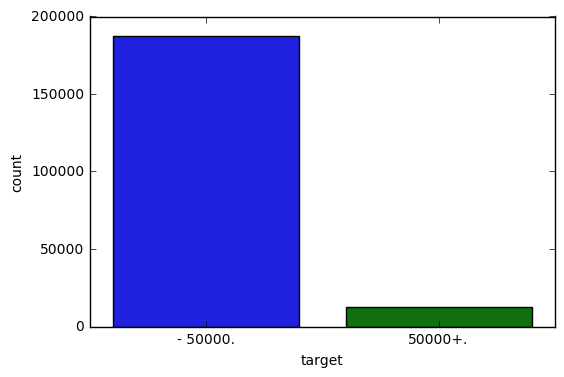

In [56]:
#Checking counts of both classes
A, B = df_learning['target'].value_counts()
print('- 50000: ',A)
print('50000+ : ',B)
sns.countplot(df_learning['target'],label="Count")
plt.show()

## Data Analysis

The columns indicated in the metadata file are almost the same as in the data. The columns 0 represents the age and column 41 is the column which we want to predict. 

The pre-processing steps which I took are as follows:

1 Converting the prediction column to binary labels ir (0 or 1) <br>
2 Using one hot encoding to convert categorical data to integer data which produced 394 features <br>
3 Feature selection using different methods


## Data Pre-Processing

In [10]:
#Function to binarize labels in the form of 0 and 1
def binarize(label):
    if label[41] == '- 50000.':
        return 0
    else:
        return 1

In [11]:
#Binarize the label of training and test set
y_train = pd.DataFrame()
y_train['labels'] = df_learning.apply(binarize, axis=1)

y_test = pd.DataFrame()
y_test['labels'] = df_test.apply(binarize, axis=1)

del df_learning['target']
del df_test['target']

y_train.head(10)

,labels
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [12]:
y_train.describe(include = 'all')

,labels
count,199523.000000
mean,0.062058
std,0.241261
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [13]:
#checking the number of ? in the data
def cc(x):
    return sum(x=='?')

df_learning.apply(cc)

age                                               0
class of worker                                   0
detailed industry recode                          0
detailed occupation recode                        0
education                                         0
wage per hour                                     0
enroll in edu inst last wk                        0
marital stat                                      0
major industry code                               0
major occupation code                             0
race                                              0
hispanic origin                                   0
sex                                               0
member of a labor union                           0
reason for unemployment                           0
full or part time employment stat                 0
capital gains                                     0
capital losses                                    0
dividends from stocks                             0
tax filer st

## One Hot Encoding of Features

Using one hot encoding to convert categorical data to integer data which produced 394 features 

In [14]:
#One-hot encode all categorical features
def one_hot_encode(df_train, df_test):
    cat_var_train = df_train.select_dtypes(include=[np.object]).columns.tolist()
    df_train_num = df_train.drop(cat_var_train, axis=1, inplace=False, errors='ignore')
    df_train_cat_dummies = pd.get_dummies(df_train[cat_var_train])
    
    # Re-merge the categorical and continuous features
    merged_train = pd.merge(df_train_cat_dummies, df_train_num, left_index=True, right_index=True, how='inner')
    
    cat_var_test = df_test.select_dtypes(include=[np.object]).columns.tolist()
    df_test_num = df_test.drop(cat_var_test, axis=1, inplace=False, errors='ignore')
    df_test_cat_dummies = pd.get_dummies(df_test[cat_var_test])
    
    # Re-merge the categorical and continuous features
    merged_test = pd.merge(df_test_cat_dummies, df_test_num, left_index=True, right_index=True, how='inner')

    
    if len(merged_train.columns) != len(merged_test.columns):
        for newcol in merged_train:
            if newcol not in merged_test.columns:
                del merged_train[newcol]
                
    return merged_train, merged_test

In [15]:
X_train, X_test = one_hot_encode(df_learning, df_test)
print('Training Set = ', X_train.shape)
print('Test Set = ', X_test.shape)

Training Set =  (199523, 394)
Test Set =  (99762, 394)


## Feature Selection

Feature selection was done using the following methods:

1 PCA  <br>
2 Univariate feature selection  <br>
3 Removing features with low variance  <br>
4 Tree based feature selection and random forest classification <br>


http://scikit-learn.org/stable/modules/feature_selection.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

### 1. PCA

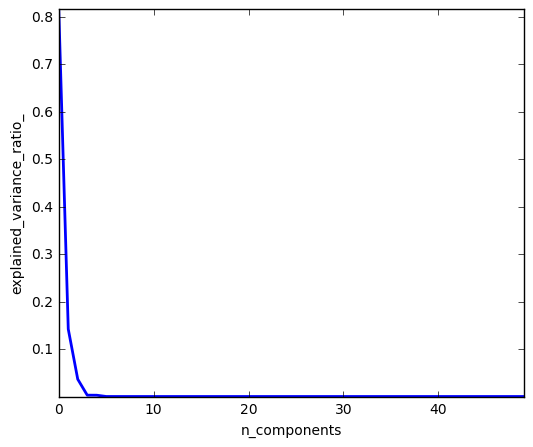

In [57]:
#Find top 50 features using PCA
pca = PCA(n_components= 50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(1, figsize=(6, 5))
plt.clf()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

### 2. Univariate feature selection

#### SelectKBest with chi2

In [17]:
#Find best scored 30 features with chi2
select_feature_kbest_1 = SelectKBest(chi2, k=30).fit(X_train, y_train.values.ravel())
X_train_kbest_1 = select_feature_kbest_1.transform(X_train)
X_test_kbest_1 = select_feature_kbest_1.transform(X_test)

#### SelectKBest with f_classif

In [18]:
#Find best scored 30 features with f_classif
select_feature_kbest_2 = SelectKBest(f_classif, k=30).fit(X_train, y_train.values.ravel())
X_train_kbest_2 = select_feature_kbest_2.transform(X_train)
X_test_kbest_2 = select_feature_kbest_2.transform(X_test)

#### SelectPercentile with chi2

In [19]:
#Find top 10 percent features with chi2
select_feature_percent_2 = SelectPercentile(chi2, percentile = 10).fit(X_train, y_train.values.ravel())
X_train_percent_2 = select_feature_percent_2.transform(X_train)
X_test_percent_2= select_feature_percent_2.transform(X_test)

#### SelectPercentile with f_classif

In [20]:
#Find top 10 percent features with f_classif
select_feature_percent_3 = SelectPercentile(f_classif, percentile = 10).fit(X_train, y_train.values.ravel())
X_train_percent_3 = select_feature_percent_3.transform(X_train)
X_test_percent_3 = select_feature_percent_3.transform(X_test)

### 3. Removing features with low variance

In [21]:
#Find features with 90% variance threshold
select_feature_var_2 = VarianceThreshold(threshold=(.9 * (1 - .9))).fit(X_train, y_train.values.ravel())
X_train_var_2 = select_feature_var_2.transform(X_train)
X_test_var_2 = select_feature_var_2.transform(X_test)

### 4. Tree based feature selection and random forest classification

In [22]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train.values.ravel())
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#### The top features which are important are clear in the following histogram which shows which of them are highly important for the classification process

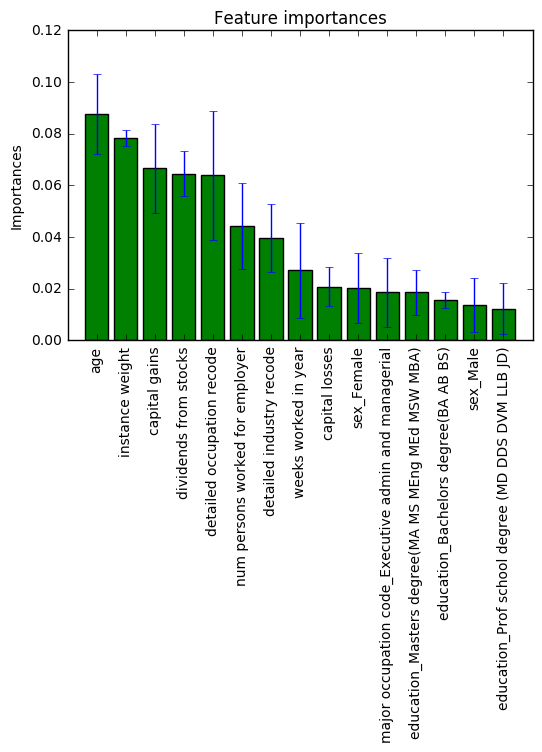

In [58]:
# Plot the feature importances of the features
plt.figure(1, figsize=(6, 4))
plt.title("Feature importances")
plt.bar(range(15), importances[indices][:15],
       color="g", yerr=std[indices][:15], align="center")
plt.ylabel('Importances')
plt.xticks(range(15), X_train.columns[indices][:15],rotation=90)
plt.xlim([-1, 15])
plt.show()

## Model Selection from Training Data

The following models were fitted on the training data with all the different feature selection methods:

Logistic Regression <br> 
Decision Tree <br>
Bernoulli Naive Bayes <br>
Gaussian Naive Bayes <br>
Random Forest <br>
Ada Boost <br>
Gradient Boosting <br> 
Neural Network <br>

Top 4 High Performing models were chosen to be tested on test data according to the Area under the ROC curve


In [24]:
# Benchmark classifiers
def benchmark(clf, train_X, test_X):
    clf.fit(train_X, y_train.values.ravel())
    pred = clf.predict(train_X)
    score = cross_val_score(clf, train_X, y_train.values.ravel(), cv=5)
    cm = confusion_matrix(y_train.values.ravel(),pred)
    fpr, tpr, thresholds = roc_curve(y_train, pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc, np.mean(score)

In [25]:
models_names = ['Logistic Regression', 'Decision Tree', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes', 'Random Forest', 'Ada Boost',
         'Gradient Boosting', 'Neural Network']

models = [LogisticRegression(),  tree.DecisionTreeClassifier(min_samples_leaf=4), BernoulliNB(), GaussianNB(), RandomForestClassifier(n_estimators=400, min_samples_leaf=4, n_jobs=-1), 
          AdaBoostClassifier(), GradientBoostingClassifier(), MLPClassifier(alpha = 1e-3) ]


features_names = ['All','SelectKBest chi2', 'SelectKBest f_classif', 'Select Percentile chi2', 'Select Percentile f_classif', 
            'Removing features with low variance', 'PCA']

features = [(X_train, X_test), (X_train_kbest_1, X_test_kbest_1), (X_train_kbest_2, X_test_kbest_2), 
            (X_train_percent_2, X_test_percent_2), (X_train_percent_3, X_test_percent_3),
           (X_train_var_2, X_test_var_2), (X_train_pca, X_test_pca)]

In [26]:
acc_train = {}
auc_train = {}
print('Training')
for clf, name in zip(models, models_names):
    for feat, feat_name in zip(features, features_names):
        final_n = name + ',' + feat_name
        auc_train[final_n], acc_train[final_n] = benchmark(clf, feat[0], feat[1])

Training


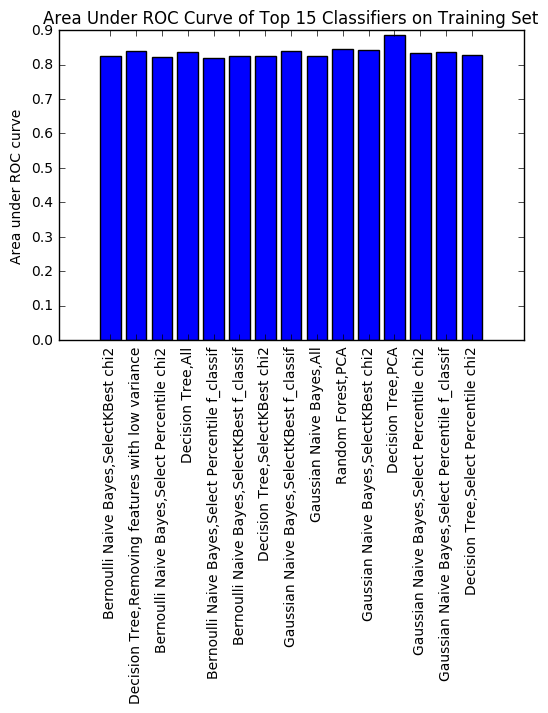

In [59]:
auc_sort= sorted(auc_train.items(), key=lambda x: x[1], reverse = True)
auc_sort = dict(auc_sort[:15])
plt.title('Area Under ROC Curve of Top 15 Classifiers on Training Set')
plt.bar(range(len(auc_sort)), auc_sort.values(), align='center')
plt.ylabel('Area under ROC curve')
plt.xticks(range(len(auc_sort)), list(auc_sort.keys()), rotation='vertical')
plt.show()

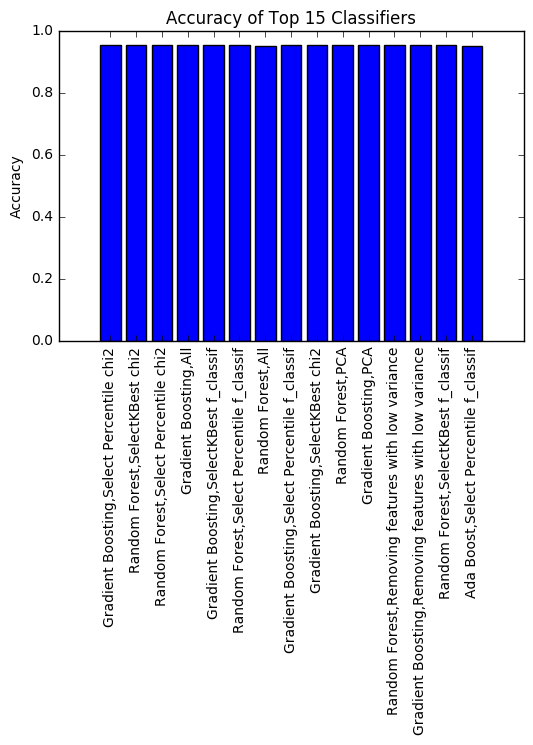

In [60]:
acc_sort= sorted(acc_train.items(), key=lambda x: x[1], reverse = True)
acc_sort = dict(acc_sort[:15])
plt.title('Accuracy of Top 15 Classifiers')
plt.bar(range(len(acc_sort)), acc_sort.values(), align='center')
plt.ylabel('Accuracy')
plt.xticks(range(len(acc_sort)), list(acc_sort.keys()), rotation='vertical')
plt.show()

## Applying Top Models to Test Data

The top performing models according to Ares under ROC

Decision Tree <br>
Bernoulli Naive Bayes <br>
Gaussian Naive Bayes <br>
Random Forest <br>

In [39]:
models_names = ['Decision Tree', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes', 'Random Forest']

models = [tree.DecisionTreeClassifier(min_samples_leaf=5), BernoulliNB(), GaussianNB(), RandomForestClassifier(n_estimators=400, min_samples_leaf=5, n_jobs=-1)]

features = [(X_train_kbest_1, X_test_kbest_1)]

Testing ...


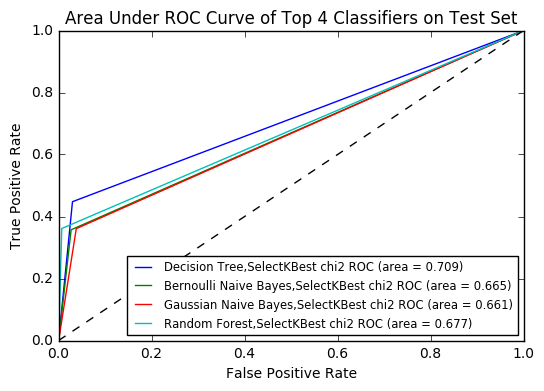

In [62]:
acc_test = {}
auc_test = {}
print('Testing ...')
for clf, name in zip(models, models_names):
    final_n = name + ',' + 'SelectKBest chi2'
    clf.fit(feat[0], y_train.values.ravel())
    pred = clf.predict(feat[1])
    score = cross_val_score(clf, feat[1], y_test.values.ravel(), cv=5)
    cm = confusion_matrix(y_test.values.ravel(),pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    auc_test[final_n] = roc_auc
    acc_test[final_n] = np.mean(score)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (final_n, roc_auc))
    
plt.title('Area Under ROC Curve of Top 4 Classifiers on Test Set')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

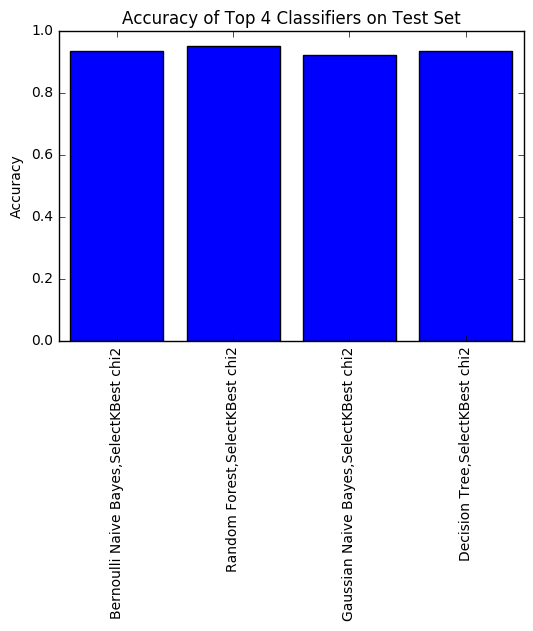

In [63]:
acc_sort_test= sorted(acc_test.items(), key=lambda x: x[1], reverse = True)
acc_sort_test = dict(acc_sort_test[:4])
plt.title('Accuracy of Top 4 Classifiers on Test Set')
plt.ylabel('Accuracy')
plt.bar(range(len(acc_sort_test)), acc_sort_test.values(), align='center')
plt.xticks(range(len(acc_sort_test)), list(acc_sort_test.keys()), rotation='vertical')
plt.show()

# Conclusion

The given data have been experimented with different models. The following insights were derived.<br>

The feature selection approach aims to select a subset of features that minimize redundancy and maximize relevance to the target such as the class labels in classification. Feature selection in our case shows clearly that features like age, weeks worked, capital gains, education etc are the factors contributing to the increase in the income of the people and in this case maximize relevance to the target classes and are clearly indicated in one of the above histograms. <br>

The difficult part was to select which features to use for the classification and also the data which was highly biased. When we train on an imbalanced dataset, the reason we get greater 94% accuracy on an imbalanced data (with 94% of the instances in Class-1) is because our models look at the data and cleverly decide that the best thing to do is to always predict “Class-1” and achieve high accuracy. This is best seen when using a simple rule based algorithm. If we analyze the rule in the final model you will see that it is very likely predicting one class regardless of the data it is asked to predict.<br>

ROC curve was used to evaluate the models. One of the advantages of ROC curves is that they are insensitive to changes in class distribution, evaluate learning in the presence of unbalanced classes. Accuracy Measure shows a slighlty different picture. It is the case where your accuracy measures tells that you have excellent accuracy (such as 90%), but the accuracy is only reflecting the underlying class distribution.<br>

Model selection is the process of choosing between different machine learning approaches - e.g. Naive Bayes, logistic regression, etc.<br>

The ROC curve above shows the top performing model is Naive Bayes as it handles the unbalanced and highly biased data well. It has the greatest Area under the ROC curve value. Naive Bayes has a higher bias but lower variance. If the data set follows the bias then Naive Bayes will be a better classifier.<br>